In [1]:
%matplotlib inline

# Model Building Part 1

In model building part one, I experiment with using macro-level text summary statistics as features.

In [2]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import Image
from IPython.core.display import HTML

In [3]:
path = '/Users/eli/Desktop/DataScienceGalvanize/dsci_6004_NLP/Amazon Reviews Analysis Projects/Amazon_Reviews_Galvanize_2017/'

In [4]:
os.chdir(path)

In [5]:
!pwd

/Users/eli/Desktop/DataScienceGalvanize/dsci_6004_NLP/Amazon Reviews Analysis Projects/Amazon_Reviews_Galvanize_2017


In [6]:
clean_data=pd.read_pickle(path+'clean_data/clean_data.pkl')

In [7]:
clean_data.head()

,helpful,num_sents,num_words,readability,neg_senti,pos_senti,neu_senti,comp_senti,text_lemma,vec0_x,...,vec290_y,vec291_y,vec292_y,vec293_y,vec294_y,vec295_y,vec296_y,vec297_y,vec298_y,vec299_y
0,0.0,0.693147,3.610918,6.742881,0.079,0.068,0.853,-0.1027,product arrive label peanut actually small siz...,-0.019901,...,-0.178709,0.120293,0.048853,-0.028560,0.024294,-0.051074,-0.082868,-0.058978,0.058156,0.020952
1,0.0,1.386294,3.555348,6.734948,0.000,0.448,0.552,0.9468,great taffy great price wide assortment yummy ...,-0.076091,...,-0.125921,0.026862,-0.011833,-0.023788,0.028657,-0.001059,-0.003236,-0.048324,-0.050874,0.113610
2,0.0,1.609438,4.521789,6.743588,0.029,0.163,0.809,0.8830,get wild hair taffy order pound bag taffy enjo...,-0.048797,...,-0.154745,0.004021,0.004185,0.006071,-0.032341,0.030001,0.004792,-0.122627,-0.015319,0.046176
3,0.0,1.609438,4.143135,6.742527,0.034,0.273,0.693,0.9346,saltwater taffy great flavor soft chewy candy ...,-0.009421,...,-0.185385,0.038134,0.014824,-0.012089,0.007642,-0.013590,0.038388,-0.117533,0.042929,0.137415
4,0.0,1.609438,3.526361,6.737915,0.000,0.480,0.520,0.9487,taffy good soft chewy flavor amazing definitel...,-0.073490,...,-0.155703,0.041312,-0.121036,-0.063175,0.075995,-0.005276,0.051416,-0.136569,0.021066,0.123007


In [8]:
kept_cols=['helpful', 'num_sents', 'num_words', 'readability', 'neg_senti',
       'pos_senti', 'neu_senti', 'comp_senti']

## Training and Testing Split - Using Sklearn Package

In [9]:
my_rand_state=0
test_size=0.25

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = (clean_data[kept_cols].iloc[:,1:]).as_matrix()
y = (clean_data[kept_cols].iloc[:,0]).tolist()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                              random_state=my_rand_state)

## Feature Selection

In [13]:
from sklearn.feature_selection import VarianceThreshold

In [14]:
vt = VarianceThreshold()
threshold=[p*(1-p) for p in [0, 0.05, 0.1, 0.15]]

## Scaling

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
std_scale=StandardScaler()

## Classification Models

In [17]:

from sklearn.neighbors import KNeighborsClassifier


Although tuning is not necessary for Naive Bayes, I pass the default parameters of those models to GridSearchCV anyway so that I can do a direct pair-wise comparison with the other models across the different steps of cross-validation.  

In the interest of time, I didn't use the SVM classifier.

In [18]:
knn_clf=KNeighborsClassifier(n_jobs=4)
n_neighbors=[2,3,4,5,6,7]
weights=['uniform','distance']

In [19]:
class_weight=['balanced']
class_weight.extend([{1: w} for w in [1, 2, 10]])

## Creating Pipelines

In [20]:
from imblearn import pipeline #needed if mixing imblearn with sklearn classes
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

I plan on using imblearn classes for later iterations so I use it's pipeline in the beginning for convenience

In [21]:
n_jobs=4

In [22]:
n_folds=10
skfold = StratifiedKFold(n_splits=n_folds,random_state=my_rand_state, shuffle=False)

# KNN Estimator

In [23]:
knn_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',knn_clf)])
knn_clf_est_b = GridSearchCV(estimator=knn_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_neighbors=n_neighbors,
              clf__weights=weights))

## Fitting Estimators

In [24]:
from sklearn.externals import joblib

In [25]:
# Calculating the time to run KNN machine learnung algorithm. Goal is to use
# the time of this algorithm against other algorithms. Time will be used as a 
# performance parameter.
import time
start = time.time()
knn_clf_est_b.fit(X_train,y_train)
stop = time.time()
duration = stop-start
print(duration)

1556.1599972248077


Basic Estimators: no bag of words or PCA

In [26]:
joblib.dump(knn_clf_est_b, './other_output/knn_clf_est_b.pkl')

['./other_output/knn_clf_est_b.pkl']

## Testing Estimators

In [27]:
from sklearn.metrics import roc_curve, auc

In [28]:

knn_clf_est_b=joblib.load('./other_output/knn_clf_est_b.pkl')


In [30]:

knn_fpr, knn_tpr, _ = roc_curve(y_test, 
                    knn_clf_est_b.predict_proba(X_test)[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)



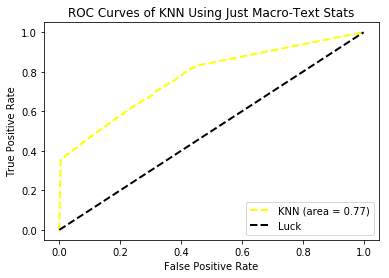

In [31]:

plt.plot(knn_fpr, knn_tpr, color='yellow', linestyle='--',
         label='KNN (area = %0.2f)' % knn_roc_auc, lw=2)


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of KNN Using Just Macro-Text Stats')
plt.legend(loc="lower right")
plt.savefig('./plots/ROC_Basic.png', bbox_inches='tight')
plt.show()